In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import anatools.analysis as ana
import tensorflow as tf
from tensorflow.keras.models import load_model

from hhdm_analysis.xgb.utils import model_performance, compute_purity_cutflow, compute_best_thr
from hhdm_analysis.utils import position, signal_label
from hhdm_analysis.fdeep import convert as convert_to_fdeep

# Disable GPUs
tf.config.set_visible_devices([], 'GPU')

ana.start()
plt.style.use("default")

2023-02-15 11:39:40.192209: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-15 11:39:42.101458: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-15 11:39:42.103499: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-15 11:39:42.183640: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 11:39:42.183720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.8GHz coreCount: 22 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 178.86GiB/s
2023-02-15 11:39:42.183790: I tensorflow/stream_executor/platform

# Setup config

In [2]:
period = 'APV_16'
year_style = 2016
dataset_year = "APV_2016"
basedir = '/home/gamoreir/SanDisk/physics/hhdmAnalysis_deepJet_Regions/datasets'

# Setup figure folders
dataset_name = basedir.split('/')[-2]
figures_path = f"./figures/{dataset_name}/{dataset_year}/machine_learning"
Path(figures_path).mkdir(parents=True, exist_ok=True)

# Data folder
data_path = f"./data/{dataset_name}/{dataset_year}"
Path(data_path).mkdir(parents=True, exist_ok=True)

# Setup models folders
models_path = f"./models/{dataset_name}/{dataset_year}"
Path(models_path).mkdir(parents=True, exist_ok=True)

# Read metadata

In [3]:
with open("../metadata.json", "r") as f:
    metadata = json.load(f)

# Read data and model

In [4]:
model_name = "MLP_multi_signal"
plot_label ="Multi-signal"

# Train and test data
X_train = pd.read_csv(f"{data_path}/{model_name}-train-data.csv")
X_test = pd.read_csv(f"{data_path}/{model_name}-test-data.csv")
W_train = X_train.pop("modelWeight").values
W_test = X_test.pop("modelWeight").values
Y_train = X_train.pop("Label").values
Y_test = X_test.pop("Label").values
evtWeight_train = X_train.pop("evtWeight").values
evtWeight_test = X_test.pop("evtWeight").values

# Model
features = ["LeadingLep_pt", "LepLep_deltaM", "LepLep_deltaR", "LepLep_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "MET_pt", "MT2LL", "Nbjets", "TrailingLep_pt"]
model = load_model(f"{models_path}/{model_name}-checkpoint.h5")

2023-02-15 11:39:45.405196: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-15 11:39:45.405315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-02-15 11:39:45.405335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      


In [5]:
X_train.head()

,LeadingLep_pt,LepLep_deltaM,LepLep_deltaR,LepLep_pt,MET_LepLep_Mt,MET_LepLep_deltaPhi,MET_pt,MT2LL,Nbjets,TrailingLep_pt
0,-1.130300,1.604904,0.349870,-1.181807,-0.884643,0.492711,-0.607189,-0.784605,-0.756234,-0.956230
1,-1.036404,-1.470962,1.092621,-1.207214,-1.005160,0.622338,-0.780956,-0.965908,-0.756234,-0.896125
2,-0.859722,-1.309577,-0.145494,-1.005630,-0.892622,-0.922285,-0.781883,-0.801464,-0.756234,-0.797736
3,-1.033726,-0.685424,0.464417,-1.139371,-0.728276,-0.096213,-0.344909,-0.643619,0.625712,-0.922024
4,-1.023518,-1.286104,0.283472,-1.149471,-0.464118,-0.041318,0.431084,-0.317362,0.625712,-0.696899


In [6]:
X_train[features].head()

,LeadingLep_pt,LepLep_deltaM,LepLep_deltaR,LepLep_pt,MET_LepLep_Mt,MET_LepLep_deltaPhi,MET_pt,MT2LL,Nbjets,TrailingLep_pt
0,-1.130300,1.604904,0.349870,-1.181807,-0.884643,0.492711,-0.607189,-0.784605,-0.756234,-0.956230
1,-1.036404,-1.470962,1.092621,-1.207214,-1.005160,0.622338,-0.780956,-0.965908,-0.756234,-0.896125
2,-0.859722,-1.309577,-0.145494,-1.005630,-0.892622,-0.922285,-0.781883,-0.801464,-0.756234,-0.797736
3,-1.033726,-0.685424,0.464417,-1.139371,-0.728276,-0.096213,-0.344909,-0.643619,0.625712,-0.922024
4,-1.023518,-1.286104,0.283472,-1.149471,-0.464118,-0.041318,0.431084,-0.317362,0.625712,-0.696899


# Predict train and test

In [7]:
# Train
Y_pred_train = model.predict(X_train[features],batch_size=256)
perf_train = model_performance(Y_train, Y_pred_train, n=1000)
ppv_train_cutflow = compute_purity_cutflow(perf_train.threshold, perf_train.fpr, perf_train.tpr, perf_train.ppv, perf_train.acc)
best_train_thr = compute_best_thr(perf_train.threshold, perf_train.tpr, perf_train.ppv)
ppv_train_cutflow.to_csv(f"{models_path}/{model_name}-ppv-train-cutflow.csv", index=False)

# Test
Y_pred_test = model.predict(X_test[features],batch_size=256)
perf_test = model_performance(Y_test, Y_pred_test, n=1000)
ppv_test_cutflow = compute_purity_cutflow(perf_test.threshold, perf_test.fpr, perf_test.tpr, perf_test.ppv, perf_test.acc)
best_test_thr = compute_best_thr(perf_test.threshold, perf_test.tpr, perf_test.ppv)
ppv_test_cutflow.to_csv(f"{models_path}/{model_name}-ppv-test-cutflow.csv", index=False)

2023-02-15 11:42:11.514612: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-15 11:42:11.515443: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599995000 Hz


In [8]:
print("Best thr:", best_train_thr)
display(ppv_train_cutflow)

Best thr: 0.990990990990991


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.100000,0.100598,0.046046,0.996416,0.319331,0.367393
1,0.200000,0.200274,0.261261,0.978951,0.701320,0.721027
2,0.300000,0.300088,0.574575,0.956162,0.829606,0.838589
3,0.400000,0.400538,0.822823,0.928816,0.893787,0.896274
4,0.500000,0.500797,0.946947,0.885662,0.932545,0.929217
5,0.600000,0.602021,0.984985,0.817191,0.958724,0.948677
6,0.700000,0.705931,0.994995,0.704717,0.977570,0.958202
7,0.800000,0.833494,0.997998,0.538026,0.991788,0.959579
8,0.900000,0.914264,0.998999,0.452009,0.996761,0.958093
9,0.646511,0.646511,0.990991,0.774410,0.967648,0.953932


In [9]:
print("Best thr:", best_test_thr)
display(ppv_test_cutflow)

Best thr: 0.992992992992993


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.10000,0.100057,0.045045,0.996209,0.315389,0.363716
1,0.20000,0.200064,0.263263,0.977294,0.701436,0.721017
2,0.30000,0.300317,0.578579,0.954712,0.830050,0.838898
3,0.40000,0.400260,0.827828,0.924589,0.894148,0.896309
4,0.50000,0.500817,0.947948,0.882699,0.932776,0.929222
5,0.60000,0.603264,0.984985,0.816466,0.958974,0.948858
6,0.70000,0.710861,0.994995,0.703909,0.978124,0.958660
7,0.80000,0.838438,0.997998,0.539394,0.992058,0.959927
8,0.90000,0.917210,0.998999,0.451470,0.996886,0.958171
9,0.67549,0.675490,0.992993,0.748120,0.972539,0.956610


# Prepare data to plot discriminant

In [10]:
X_train["MLP_score_keras"] = Y_pred_train
X_test["MLP_score_keras"] = Y_pred_test
X_train["modelWeight"] = W_train
X_test["modelWeight"] = W_test
X_train["Label"] = Y_train
X_test["Label"] = Y_test
X_train["evtWeight"] = evtWeight_train
X_test["evtWeight"] = evtWeight_test

# Plot discriminant using modelWeight

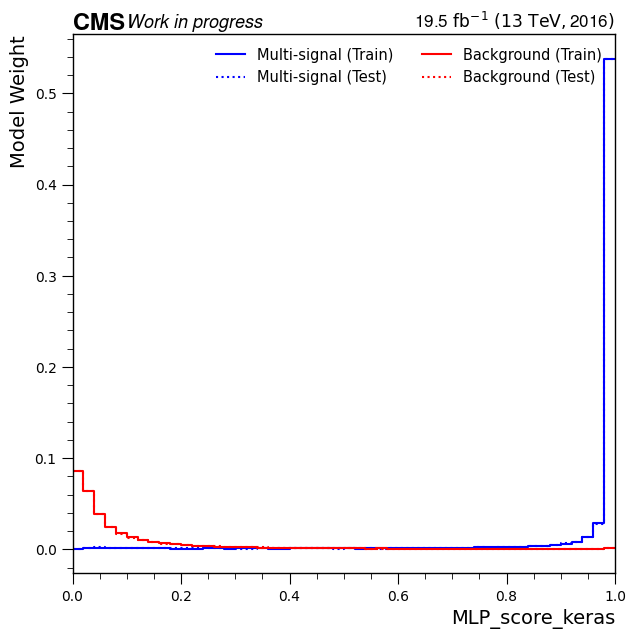

In [11]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ana.step_plot(ax1, "MLP_score_keras", X_train[X_train.Label == 1], label=f"{plot_label} (Train)", color="blue", weight="modelWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "MLP_score_keras", X_test[X_test.Label == 1], label=f"{plot_label} (Test)", color="blue", weight="modelWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")
ana.step_plot(ax1, "MLP_score_keras", X_train[X_train.Label == 0], label="Background (Train)", color="red", weight="modelWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "MLP_score_keras", X_test[X_test.Label == 0], label="Background (Test)", color="red", weight="modelWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")

ana.labels(ax1, ylabel="Model Weight", xlabel="MLP_score_keras")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=2, #ylim=[0, 1]
)
plt.savefig(f"{figures_path}/MLP_score_keras-modelWeight-{model_name}.png", dpi=200, facecolor='white')
plt.show()

# Plot discriminant using evtWeight

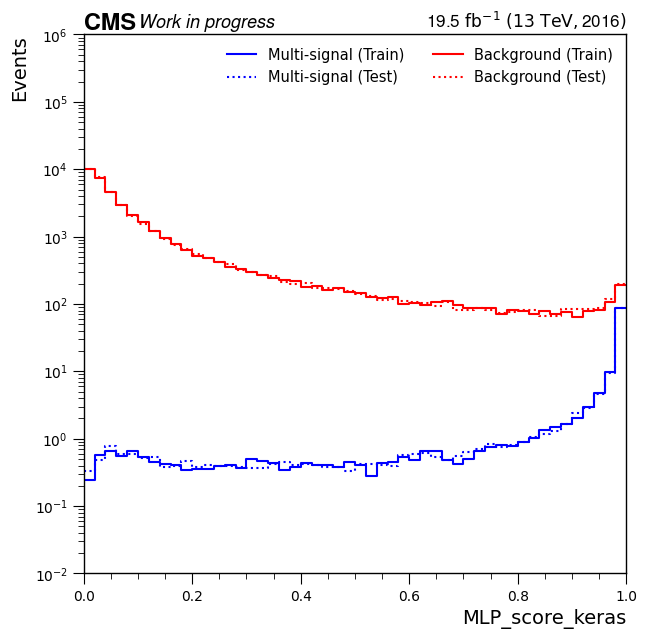

In [12]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ana.step_plot(ax1, "MLP_score_keras", X_train[X_train.Label == 1], label=f"{plot_label} (Train)", color="blue", weight="evtWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "MLP_score_keras", X_test[X_test.Label == 1], label=f"{plot_label} (Test)", color="blue", weight="evtWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")
ana.step_plot(ax1, "MLP_score_keras", X_train[X_train.Label == 0], label="Background (Train)", color="red", weight="evtWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "MLP_score_keras", X_test[X_test.Label == 0], label="Background (Test)", color="red", weight="evtWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")

ana.labels(ax1, ylabel="Events", xlabel="MLP_score_keras")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, ylim=[1e-2, 1e6]
)
plt.savefig(f"{figures_path}/MLP_score_keras-evtWeight-{model_name}.png", dpi=200, facecolor='white')
plt.show()

# Convert model to frugally-deep format to be used in C++

In [13]:
convert_to_fdeep(
    f"{models_path}/{model_name}-checkpoint.h5",
    f"{models_path}/{model_name}-checkpoint.json",
    False
)

loading ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
Forward pass took 0.08747 s.
Forward pass took 0.050002 s.
Forward pass took 0.047742 s.
Starting performance measurements.
Forward pass took 0.068017 s.
Forward pass took 0.046813 s.
Forward pass took 0.052876 s.
Forward pass took 0.048747 s.
Forward pass took 0.048492 s.
Forward pass took 0.052988999999999994 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model hash.
Model conversion finished.
writing ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.json
